In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
import torchmetrics
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from matplotlib import pyplot as plt
import os
from pathlib import Path
from PIL import Image

In [2]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = []
        self.labels = []

        # Populate image file paths and labels
        for sub_dir in os.listdir(folder_path):
            full_path = os.path.join(folder_path, sub_dir)
            img_names = [f for f in os.listdir(full_path) if f.endswith('.png')]
            full_image_path = [os.path.join(full_path, s) for s in img_names]
            self.image_files.extend(full_image_path)

        # Store tumor type in self.labels (0 = fused glands, 1 = 141541, 2 = solid)
        for img in self.image_files:
            slide_num = img.split("/")[-2].split("_")[0]
            tissue_num = img.split("_")[-2]
            if slide_num == "SQ1631":
                if tissue_num == "s1":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1632":
                if tissue_num == "s4":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1633":
                if tissue_num == "s2":
                    self.labels.append(0)
                else:
                    self.labels.append(2)
            elif slide_num == "SQ1634":
                if tissue_num == "s2":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1635":
                if tissue_num == "s3" or tissue_num == "s4":
                    self.labels.append(2)
                elif tissue_num == "s1":
                    self.labels.append(1)
                else:
                    self.labels.append(0)
            else:
                if tissue_num == "s4":
                    self.labels.append(1)
                else:
                    self.labels.append(2)
                
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx]).convert('RGB') 
        label = self.labels[idx]  # Get the corresponding label
        if self.transform:
            image = self.transform(image)

        return image, label  # Return both image and label

In [3]:
# Define transformations (if needed)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 128x128 pixels
    transforms.ToTensor(),           # Convert to tensor
])

# Create dataset and dataloadercal
folder_path = '/home/mass_spec_img/mass_spec_img/data/raw_img/'
dataset = CustomImageDataset(folder_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

tensor([0, 1, 1, 2, 1, 1, 2, 1, 0, 2, 2, 1, 2, 1, 0, 2, 0, 2, 2, 0, 1, 2, 0, 1,
        2, 2, 0, 2, 2, 1, 1, 1])


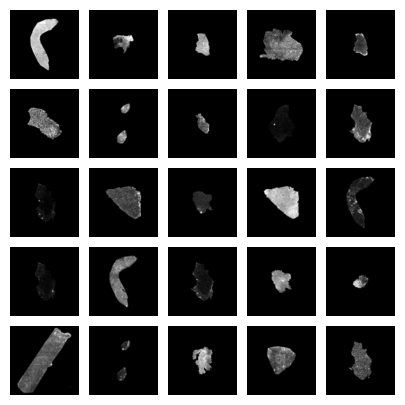

In [25]:
# Get a batch of 25 images for visualization
dataiter = iter(dataloader)
images, labels = next(dataiter)  # Unpack images and labels
print(labels)
num_samples = 25
sample_images = [images[i, 0].numpy() for i in range(num_samples)]  # Convert images to numpy

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_shape=(1, 128, 128), latent_dim=20):
        super(VAE, self).__init__()
        
        # Encoder convolutional layers
        self.enc_conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)  # For grayscale input
        self.enc_conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)

        # Calculate the flattened size after convolutions
        self.flattened_shape, self.flattened_size = self._get_flattened_size(input_shape)
        
        # Encoder fully connected layers
        self.enc_fc1 = nn.Linear(self.flattened_size, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        
        # Decoder fully connected layers
        self.dec_fc1 = nn.Linear(latent_dim, 128)
        self.dec_fc2 = nn.Linear(128, self.flattened_size)

        # Decoder convolutional layers
        self.dec_conv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.dec_conv2 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)

    def _get_flattened_size(self, input_shape):
        """Pass a dummy input through conv layers to determine the flattened size."""
        x = torch.zeros(1, *input_shape)  # Create a dummy input
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        flattened_shape = x.shape[1:]  # Save shape for reshaping in decoder
        flattened_size = x.numel()     # Total size after flattening
        return flattened_shape, flattened_size

    def encode(self, x):
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.enc_fc1(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = F.relu(self.dec_fc1(z))
        x = F.relu(self.dec_fc2(x))
        x = x.view(-1, *self.flattened_shape)  # Dynamically reshape to match encoder output
        x = F.relu(self.dec_conv1(x))
        x = torch.sigmoid(self.dec_conv2(x))  # Output in [0, 1]
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [27]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (Binary Cross-Entropy)
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL Divergence loss
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + kl_div

In [28]:
import torch.optim as optim
import time
import matplotlib.pyplot as plt

# Hyperparameters
latent_dim = 20
epochs = 10
learning_rate = 1e-3

# Model, optimizer, and device setup
device = torch.device("cpu")
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
training_loss = []
epoch_times = []

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    
    start_time = time.time()  # Start timer for epoch
    
    for images, labels in dataloader:  # Assuming dataloader is your DataLoader for the images
        images = images.to(device)
        
        # Forward pass
        recon_images, mu, logvar = model(images)
        
        # Compute loss
        loss = vae_loss(recon_images, images, mu, logvar)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    end_time = time.time()
    
    avg_loss = train_loss / len(dataloader)
    training_loss.append(avg_loss)
    
    # Calculate and store epoch duration
    epoch_duration = end_time - start_time
    epoch_times.append(epoch_duration)
    
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Time: {epoch_duration:.2f} sec")

Epoch 1/10, Loss: 372295.6512, Time: 124.24 sec
Epoch 2/10, Loss: 38131.1193, Time: 145.57 sec
Epoch 3/10, Loss: 37261.7892, Time: 160.15 sec
Epoch 4/10, Loss: 36918.9519, Time: 170.12 sec
Epoch 5/10, Loss: 36704.6925, Time: 173.10 sec
Epoch 6/10, Loss: 36566.5253, Time: 181.79 sec
Epoch 7/10, Loss: 36397.5658, Time: 184.22 sec
Epoch 8/10, Loss: 36279.8549, Time: 198.26 sec
Epoch 9/10, Loss: 36178.2460, Time: 202.08 sec
Epoch 10/10, Loss: 36092.2355, Time: 209.73 sec


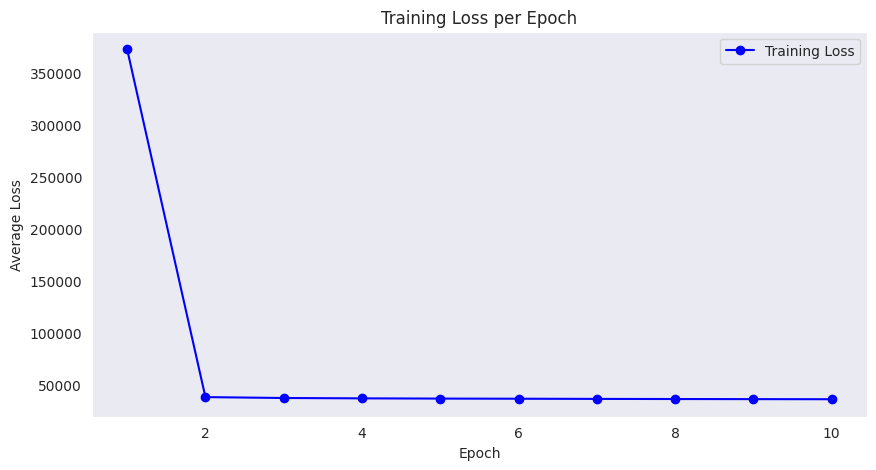

In [29]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), training_loss, marker='o', color='b', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid()
plt.show()

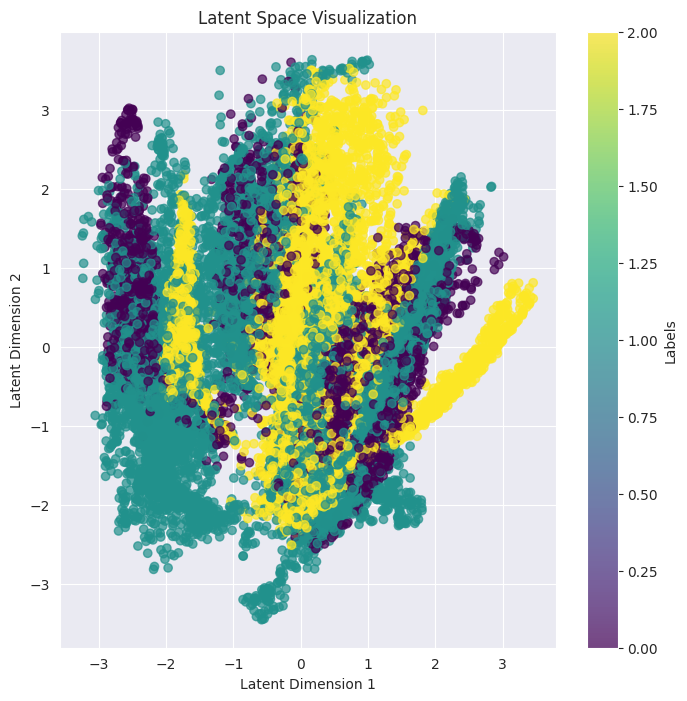

In [30]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch

def visualize_latent_space(model, dataloader, latent_dim=2, use_tsne=False):
    model.eval()
    latents = []
    labels = []

    with torch.no_grad():
        for images, label in dataloader:
            images = images.to(next(model.parameters()).device)
            mu, _ = model.encode(images)  # Only use the mean for visualization
            latents.append(mu.cpu())
            labels.append(label)

    latents = torch.cat(latents).numpy()
    labels = torch.cat(labels).numpy()

    if latent_dim > 2:
        if use_tsne:
            latents_2d = TSNE(n_components=2).fit_transform(latents)
        else:
            latents_2d = PCA(n_components=2).fit_transform(latents)
    else:
        latents_2d = latents  # If already 2D, no reduction needed

    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap="viridis", alpha=0.7)
    plt.colorbar(scatter, label="Labels")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Latent Space Visualization")
    plt.show()

visualize_latent_space(model, dataloader, latent_dim=20, use_tsne=False)


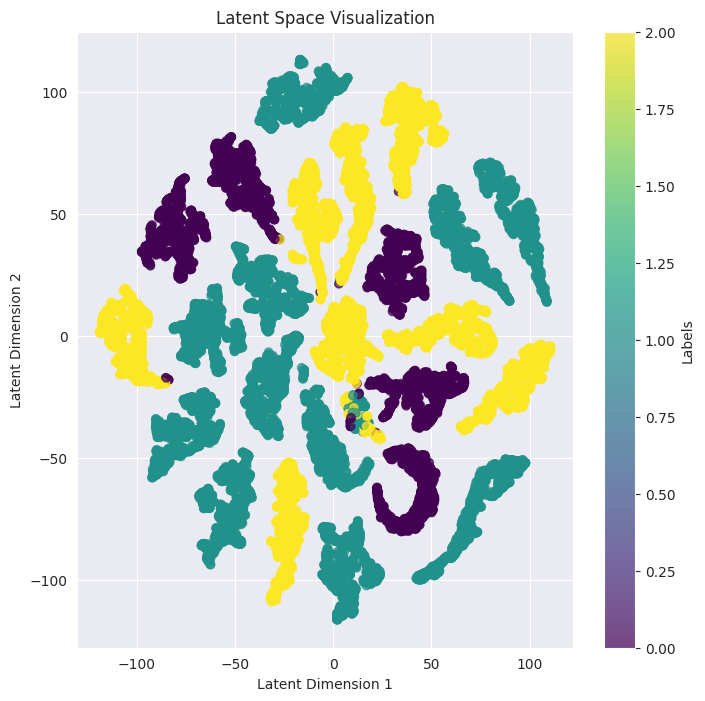

In [31]:
visualize_latent_space(model, dataloader, latent_dim=20, use_tsne=True)

In [32]:
import torch.nn as nn
def extract_latent_features(model, dataloader):
    model.eval()
    latents = []
    labels = []

    with torch.no_grad():
        for images, label in dataloader:
            images = images.to(next(model.parameters()).device)
            mu, _ = model.encode(images)  # Only use mu as the latent representation
            latents.append(mu.cpu())
            labels.append(label)

    latents = torch.cat(latents)
    labels = torch.cat(labels)
    return latents, labels

latent_vectors, target_labels = extract_latent_features(model, dataloader)


In [33]:
latent_features_np = latent_vectors.cpu().numpy()  # Move to CPU and convert to NumPy
target_labels_np = target_labels.cpu().numpy()
np.save("latent_features.npy", latent_features_np)
np.save("target_labels.npy", target_labels_np)

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

latent_features = np.load("latent_features.npy")
labels = np.load("target_labels.npy") 

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(latent_features, labels, test_size=0.2, random_state=42)

# Train a classifier on the latent features
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Evaluate the classifier
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy * 100:.2f}%")

Accuracy on test set: 99.68%


In [ ]:
import os
from PIL import Image
import torch
import zarr
import numpy as np
sample_ls = ['SQ1631_s1_R', 'SQ1631_s2_R', 'SQ1631_s3_N', 'SQ1631_s4_N',
                 'SQ1632_s1_R', 'SQ1632_s2_N', 'SQ1632_s3_R', 'SQ1632_s4_N',
                 'SQ1633_s1_R', 'SQ1633_s2_R', 'SQ1633_s3_N', 'SQ1633_s4_N',
             'SQ1634_s1_N', 'SQ1634_s2_R', 'SQ1634_s3_R', 'SQ1634_s4_N',
             'SQ1635_s1_N', 'SQ1635_s2_R', 'SQ1635_s3_R', 'SQ1635_s4_N',
             'SQ1636_s1_R', 'SQ1636_s2_N', 'SQ1636_s3_N', 'SQ1636_s4_R']

tile_ls = []
label_ls = []

folder_path = '/home/mass_spec_img/mass_spec_img/data/zarr'
for sample in sample_ls:
    zarr_path = f'{folder_path}/{sample}/slide.zarr'
    slide = zarr.open(zarr_path, mode='r')
    print(f'Zarr dataset loaded from {zarr_path}')
    tile_ls.append(slide)
    if sample.startswith("SQ1631"):
        if "s1" in sample:
            label_ls.append(0)
        else:
            label_ls.append(1)
    elif sample.startswith("SQ1632"):
        if "s4" in sample:
            label_ls.append(0)
        else:
            label_ls.append(1)
    elif sample.startswith("SQ1633"):
        if "s2" in sample:
            label_ls.append(0)
        else:
            label_ls.append(2)
    elif sample.startswith("SQ1634"):
        if "s2" in sample:
            label_ls.append(0)
        else:
            label_ls.append(1)
    elif sample.startswith("SQ1635"):
        if "s3" in sample or "s4" in sample:
            label_ls.append(2)
        elif "s1" in sample:
            label_ls.append(1)
        else:
            label_ls.append(0)
    else:
        if "s4" in sample:
            label_ls.append(1)
        else:
            label_ls.append(2)

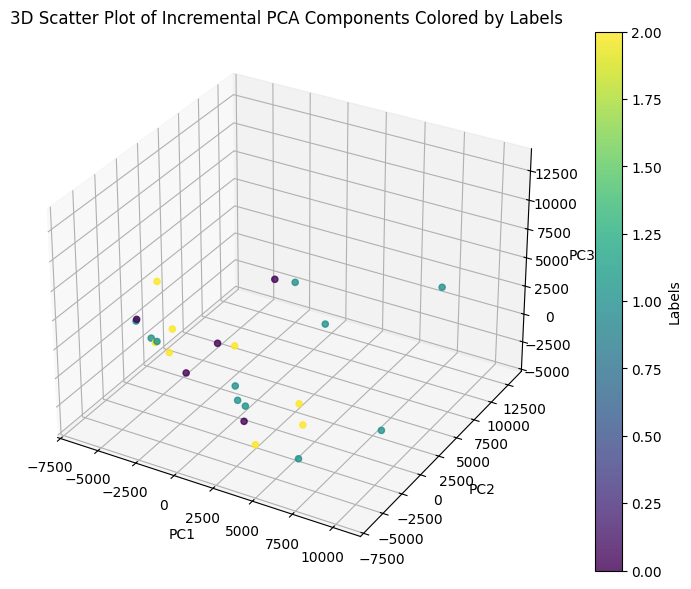

In [48]:
from sklearn.decomposition import IncrementalPCA
import matplotlib.pyplot as plt


mean_data = tile_ls.mean(axis=1)  # shape: (24, 500, 500)

reshaped_data = mean_data.reshape(24, -1)  # reshaped: (24, 250000)

n_components = 3
batch_size = 5 
ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size)
pca_result = ipca.fit_transform(reshaped_data)  # Shape: (24, 3)

# Step 4: 3D Scatter Plot with color based on labels
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], 
                c=label_ls, cmap='viridis', alpha=0.8)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.colorbar(sc, ax=ax, label="Labels")
plt.title("3D Scatter Plot of Incremental PCA Components Colored by Labels")
plt.show()


In [70]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

images_pca = []
for img in tile_ls:
    # reshape to (height * width, channels)
    reshaped_img = img.reshape(-1, 917)
    img_reduced = pca.fit_transform(reshaped_img)
    
    # reshape back to (height, width, 3)
    img_pca = img_reduced.reshape(500, 500, 3)
    images_pca.append(img_pca)

# Convert list back to array, now with shape (num_images, height, width, 3)
images_pca = np.array(images_pca)

In [72]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
print("before:", images_pca.shape)
images_tensor = torch.tensor(images_pca, dtype=torch.float32).permute(0, 3, 1, 2)  # shape: (num_images, 3, height, width)
print("after:", images_pca.shape)
labels = torch.tensor(label_ls, dtype=torch.long)  # assuming labels is an array with class labels
print(labels.shape, len(label_ls))

# split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images_tensor, labels, test_size=0.2, random_state=42)

batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)

before: (24, 500, 500, 3)
after: (24, 500, 500, 3)
torch.Size([24]) 24


In [61]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * (500 // 8) * (500 // 8), 128) 
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, len(torch.unique(labels)))

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * (500 // 8) * (500 // 8))
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleCNN()

In [62]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [63]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # calculate average validation loss and accuracy
    val_loss /= len(val_loader.dataset)
    accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Accuracy: {accuracy:.2f}%")

Epoch 1/20, Train Loss: 2.9525, Val Loss: 10509.1582, Accuracy: 20.00%
Epoch 2/20, Train Loss: 5814.2954, Val Loss: 4498.7178, Accuracy: 20.00%
Epoch 3/20, Train Loss: 4357.8770, Val Loss: 489.2145, Accuracy: 60.00%
Epoch 4/20, Train Loss: 845.0521, Val Loss: 135.1507, Accuracy: 20.00%
Epoch 5/20, Train Loss: 114.5011, Val Loss: 31.3444, Accuracy: 20.00%
Epoch 6/20, Train Loss: 15.1890, Val Loss: 22.6839, Accuracy: 0.00%
Epoch 7/20, Train Loss: 23.8764, Val Loss: 14.8079, Accuracy: 60.00%
Epoch 8/20, Train Loss: 5.4808, Val Loss: 7.4113, Accuracy: 20.00%
Epoch 9/20, Train Loss: 0.4385, Val Loss: 9.1816, Accuracy: 0.00%
Epoch 10/20, Train Loss: 1.2753, Val Loss: 6.6015, Accuracy: 20.00%
Epoch 11/20, Train Loss: 1.0401, Val Loss: 3.8277, Accuracy: 20.00%
Epoch 12/20, Train Loss: 0.1366, Val Loss: 1.9972, Accuracy: 40.00%
Epoch 13/20, Train Loss: 0.0903, Val Loss: 1.8701, Accuracy: 20.00%
Epoch 14/20, Train Loss: 0.0303, Val Loss: 1.8264, Accuracy: 40.00%
Epoch 15/20, Train Loss: 0.0045, 

In [76]:
class PCADataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx].astype(np.float32)  # convert to float for normalization
        label = self.labels[idx]
        if self.transform:
            image = self.transform(torch.tensor(image))
        return image, label


In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report

# load pre-trained resnet18 model
model = models.resnet18(pretrained=True)

# freeze model parameters
for param in model.parameters():
    param.requires_grad = False

num_classes = 3 
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)  # replace the final fully connected layer


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # normalize as ImageNet
])

train_data = PCADataset(X_train, y_train, transform=transform)
val_data = PCADataset(X_val, y_val, transform=transform)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001) 


num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to("cpu"), labels.to("cpu")

        optimizer.zero_grad()  # zero the parameter gradients
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

# evaluate the Model
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to("cpu"), labels.to("cpu")
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Classification Report:\n", classification_report(all_labels, all_preds))

Epoch 1/10, Loss: 1.2621097564697266
Epoch 2/10, Loss: 1.060677409172058
Epoch 3/10, Loss: 1.015483021736145
Epoch 4/10, Loss: 1.033068060874939
Epoch 5/10, Loss: 1.026059627532959
Epoch 6/10, Loss: 0.9852786660194397
Epoch 7/10, Loss: 0.9298763275146484
Epoch 8/10, Loss: 0.879615068435669
Epoch 9/10, Loss: 0.8446021676063538
Epoch 10/10, Loss: 0.8226216435432434
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.33      0.33      0.33         3

    accuracy                           0.20         5
   macro avg       0.11      0.11      0.11         5
weighted avg       0.20      0.20      0.20         5


/root/anaconda3/envs/mass_spec_img/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/anaconda3/envs/mass_spec_img/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/anaconda3/envs/mass_spec_img/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [37]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("facebook/convnext-tiny-224")

In [39]:
train_size = int(0.7 * len(dataset))  # 70% for training
test_size = len(dataset) - train_size  # Remaining 30% for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [46]:
from transformers import ConvNextImageProcessor, ConvNextForImageClassification

model = ConvNextForImageClassification.from_pretrained("facebook/convnext-tiny-224")

num_classes = 3 # number of classes in the output
model.classifier[-1] = nn.Linear(in_features=model.classifier[-1].in_features, out_features=num_classes)

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [62]:
from tqdm.notebook import tqdm
import torch

criterion = nn.CrossEntropyLoss()

# Optimizer (e.g., AdamW)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

# Scheduler (optional)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

def train(model, train_loader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Zero gradients
        outputs = model(inputs).logits  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters
        
        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}")


In [64]:
def evaluate(model, test_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # No gradient computation
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    
    epoch_loss = running_loss / len(test_loader)
    epoch_acc = correct / total
    print(f"Test Loss: {epoch_loss:.4f}, Test Accuracy: {epoch_acc:.4f}")

In [65]:
num_epochs = 5

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train(model, train_loader, criterion, optimizer, device)
    evaluate(model, test_loader, criterion, device)
    scheduler.step()  # Update learning rate (if scheduler is used)

Epoch 1/5


  0%|          | 0/482 [00:00<?, ?it/s]

Train Loss: 0.0025, Train Accuracy: 0.9992


Evaluating:   0%|          | 0/207 [00:00<?, ?it/s]

Test Loss: 0.0014, Test Accuracy: 0.9994
Epoch 2/5


  0%|          | 0/482 [00:00<?, ?it/s]

Train Loss: 0.0009, Train Accuracy: 0.9997


Evaluating:   0%|          | 0/207 [00:00<?, ?it/s]

Test Loss: 0.0007, Test Accuracy: 0.9998
Epoch 3/5


  0%|          | 0/482 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Accuracy: 0.9999


Evaluating:   0%|          | 0/207 [00:00<?, ?it/s]

Test Loss: 0.0012, Test Accuracy: 0.9995
Epoch 4/5


  0%|          | 0/482 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Accuracy: 0.9999


Evaluating:   0%|          | 0/207 [00:00<?, ?it/s]

Test Loss: 0.0010, Test Accuracy: 0.9995
Epoch 5/5


  0%|          | 0/482 [00:00<?, ?it/s]

Train Loss: 0.0002, Train Accuracy: 0.9999


Evaluating:   0%|          | 0/207 [00:00<?, ?it/s]

Test Loss: 0.0002, Test Accuracy: 1.0000
